<a href="https://colab.research.google.com/github/AssafSinger94/StatisticalNLP19/blob/master/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import string
from collections import Counter
from sklearn import preprocessing
from random import shuffle

In [182]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
# Files and directories
# Folder when running on Google Colab
folder = "/content/gdrive/My Drive/NLP2019/"
# # Folder when running local on computer 
# folder = ""
folder = "/content/gdrive/My Drive/NLP2019/"
training_set_file_name = "pnp-train - Complete.txt"
validation_set_file_name = "pnp-validate.txt"
test_set_file_name = "pnp-test.txt"

In [0]:
# Threshold for minimum counts for sequences, below threshold sequence is not accounted in feature vector
COUNTS_THRESHOLD_HIGH = 80
COUNTS_THRESHOLD_MEDIUM = 50
COUNTS_THRESHOLD_LOW = 30

# Get all training set names
inputs = [line.rstrip('\n').lower().split('\t')[1] for line in open(folder + training_set_file_name, 'r', encoding='iso-8859-1')]

'''
Creates dictionary that assigns column/index number for each n-gram with more counts than threshold
:param n: length of n-gram
:param n_gram_counts_threshold: Threshold for counts in order to be included 
'''
def get_top_n_gram_dictionary(n, n_gram_counts_threshold):
    # Initialize n-gram counts dictionary
    n_gram_counts = {}
    for input in inputs:
    # Get over all n-grams, and set counts for each n-gram
        for i in range(max(len(input) - (n - 1), 0)):
            n_gram_counts[input[i: i + n]] = n_gram_counts.get(input[i: i + n], 0) + 1
    # Filter only n-gram with more counts than the specified threshold
    filtered_n_grams = {k: v for k, v in n_gram_counts.items() if v > n_gram_counts_threshold}
    # Convert each n-gram in filtered dictionary to index
    return {k: v for v, k in enumerate(filtered_n_grams.keys())}

#-----Unigrams-----
unigram_to_index = get_top_n_gram_dictionary(1, COUNTS_THRESHOLD_HIGH)
#-----Bigrams-----
bigram_to_index = get_top_n_gram_dictionary(2, COUNTS_THRESHOLD_HIGH)
#-----Trigrams-----
trigram_to_index = get_top_n_gram_dictionary(3, COUNTS_THRESHOLD_MEDIUM)
#-----4-grams-----
four_gram_to_index = get_top_n_gram_dictionary(4, COUNTS_THRESHOLD_MEDIUM)
#-----5-grams-----
five_gram_to_index = get_top_n_gram_dictionary(5, COUNTS_THRESHOLD_LOW)
#-----6-grams-----
six_gram_to_index = get_top_n_gram_dictionary(6, COUNTS_THRESHOLD_LOW)
#-----7-grams-----
seven_gram_to_index = get_top_n_gram_dictionary(7, COUNTS_THRESHOLD_LOW)
#-----8-grams-----
eight_gram_to_index = get_top_n_gram_dictionary(8, COUNTS_THRESHOLD_LOW)


class FeatureVector(object):
    '''
    classdocs
    '''


    def __init__(self):
        '''
        Constructor
        '''
    
    '''
    Converts name into n-gram counts vector, for specific n
    :param name: name/sentence/input to convert to feature vector
    :param n: length of n-gram
    :param n_gram_to_index: dictionary from n-gram to sequence
    '''
    def n_gram_vector(self, name, n, n_gram_to_index):
        # Initialize n-gram vector
        n_gram_vector = [0 for i in range(len(n_gram_to_index.items()))]
        # Turn name to lowercase
        name = name.lower()
        # Go over name and count n-gram using n-gram vector
        for i in range(max(len(name) - (n - 1), 0)):
            if (name[i: i + n] in n_gram_to_index):
                n_gram_vector[n_gram_to_index.get(name[i: i + n])] += 1
        return n_gram_vector
    
    def unigram_vector(self, name):
        return self.n_gram_vector(name, 1, unigram_to_index)

    def bigram_vector(self, name):
        return self.n_gram_vector(name, 2, bigram_to_index)

    def trigram_vector(self, name):
        return self.n_gram_vector(name, 3, trigram_to_index)

    def four_gram_vector(self, name):
        return self.n_gram_vector(name, 4, four_gram_to_index)
      
    def five_gram_vector(self, name):
        return self.n_gram_vector(name, 5, five_gram_to_index)
      
    def six_gram_vector(self, name):
        return self.n_gram_vector(name, 6, six_gram_to_index)
      
    def seven_gram_vector(self, name):
        return self.n_gram_vector(name, 7, seven_gram_to_index)
      
    def eight_gram_vector(self, name):
        return self.n_gram_vector(name, 8, eight_gram_to_index)
    
    
    def convert_to_feature_vector(self, name):
        feature_vector = self.unigram_vector(name) + self.bigram_vector(name) + self.trigram_vector(name) + self.four_gram_vector(name) + self.five_gram_vector(name) + self.six_gram_vector(name) + self.seven_gram_vector(name) + self.eight_gram_vector(name)
        return feature_vector


In [0]:
# Hyperparameters
LEARNING_RATE   = 0.25
EPSILON         = 0.2
LAMBDA_R        = 0.01
BATCH_SIZE      = 512
ITERATIONS      = 2000

# Dictionaries for class representation
class_label_to_number = {
    "drug" : 0,
    "person" : 1,
    "place" : 2,
    "movie" : 3,
    "company" : 4
    }

number_to_class_label = {k: v for v, k in class_label_to_number.items()}

# Feature vector converter
feature_vector = FeatureVector()

In [0]:
class Model(object):
    '''
    classdocs
    '''

    '''
    Constructor
    
    :param X: Matrix of inputs {Xi}i=1..m
    :param Y: Vector of corresponding class labels {Yi}i=1..m
    :param classes_count: Number of different class labels
    :param alpha: Learning rate of gradient ascent optimization
    :param epsilon: Halting threshold of gradient ascent optimization
    :param lambda_r: regularization value for loss function
    '''
    def __init__(self, X, Y, X_valid, Y_valid, classes_count, alpha, epsilon, lambda_r, batch_size, iterations):
        self.X          = X
        self.Y          = Y
        self.m          = self.X.shape[0]
        self.D_in       = self.X.shape[1]
        self.classes_count  = classes_count
        # W is matrix of dimensions (classes x input_dim)
        self.W          = np.random.uniform(0, 1,(self.classes_count, self.D_in))
        self.alpha      = alpha
        self.epsilon    = epsilon
        self.lambda_r   = lambda_r
        self.batch_size = batch_size
        self.batches_per_epoch = (self.m / self.batch_size) + 1
        self.iterations = iterations
        
        self.training_loss_history = []
        self.training_accuracy_history = []
        self.X_valid    = X_valid
        self.Y_valid    = Y_valid
        self.validation_loss_history = []
        self.validation_accuracy_history = []

    
    def all_conditional_prob(self, Xi):
        # Multiply features by weightes
        scores = np.dot(self.W, Xi.T)
        # scale so all values or zero or negative
        scores = np.subtract(scores, np.max(scores))
        # Make into exponent
        scores = np.exp(scores)
        # Compute sum of all scores
        scores_sum = np.sum(scores)
        # divide all scores by sum
        probabilities = scores / scores_sum
        # return probability list
        return probabilities
        
    '''
    Compute conditional probability P(y|Xi,W)
    Equal to exp(Wy*Xi)/sum( exp( Wy'*Xi)) 
    :param Xi: feature vector of input Xi (also known as f(Xi))
    :param y: Class label y (1D value/Scalar)
    '''
    def conditional_prob(self, Xi, y):
        # Get probability list of P(y|Xi,W) for all y
        probabilities = self.all_conditional_prob(Xi)
        # Return probability
        return probabilities[y]
    
    '''
    Indicator function I(y1 == y2). Returns 1 if y1==y2, 0 otherwise
    '''
    def indicator(self, y1, y2):
            return (1 if (y1 == y2) else 0)
        
    
    '''
    Computes gradient of loss function relative to Wy dL/dWy
    :param X: Matrix of inputs {Xi}i=1..m
    :param Y: Vector of corresponding class labels {Yi}i=1..m
    :param W: Weight Matrix
    :param y: class label in which gradient is calculated with respect to. (1D value/Scalar)
    :param lambdaR: Regularization ratio
    '''
    def compute_gradient_of_loss(self, X, Y, W, y):
        # Initialize dL/dWy to vector of zeroes (of dimension Wy) 
        dLdWy = np.zeros(self.D_in)
        # Get number of training points
        train_point_count = X.shape[0]
        for i in range(train_point_count):
            # Add dL/dWy for {Xi,Yi}
            dLdWy = np.add(dLdWy, X[i] * self.indicator(Y[i], y))
            dLdWy = np.subtract(dLdWy, X[i] * self.conditional_prob(X[i], y))
        dLdWy = np.subtract(dLdWy, 2 * self.lambda_r * W[y])
        return dLdWy
    
    '''
    Runs one iteration of string update: W = W + alpha*dL/dW
    '''
    def update_weights(self, start_point):
        #Initialize dLdW with random values 
        dLdW = np.zeros((self.classes_count, self.D_in))
        # Set end_point
        end_point = min(start_point + self.batch_size, self.m)
        # Go over for each y in classes, set dLdW[y] = dLdWy 
        for y in range(self.classes_count):
            dLdW[y] = self.compute_gradient_of_loss(self.X[start_point : end_point], self.Y[start_point : end_point], self.W, y)
        # W = W + alpha * dLdW
        self.W = np.add(self.W, self.alpha * dLdW)
                
    '''
    Computes loss function of Dataset with current weights W
    :param X: Matrix of inputs {Xi}i=1..m
    :param Y: Vector of class labels {Xi}i=1..m
    :param W: Weight Matrix
    :param lambdaR: Regularization ratio
    '''
    def loss(self, X, Y, W, lambda_r):
        # Total loss
        loss = 0.0
        # Go over every data point in data set, which is number of rows in X
        m = X.shape[0]
        for i in range(m):
            # Compute loss for {Xi,Yi}
            loss += np.log(self.conditional_prob(X[i], Y[i]))
        # Subtract regularization value
        loss -= lambda_r * np.square(LA.norm(W))
        return loss
      
    def accuracy(self, X, Y):
        y_pred = []
        correct_calls = 0.0
        
        # Go over every data point in data set, which is number of rows in X
        m = X.shape[0]
        for i in range(m):
            if (Y[i] == self.predict(X[i])):
                correct_calls += 1
        return correct_calls / m
    
    def fit(self):
        # Print model hyperparameters
        print("W dimensions:", self.W.shape)
        print ("alpha: ", self.alpha)
        print("epsilon: ", self.epsilon)
        print("lambda: ", self.lambda_r)
        print("batch size: ",  self.batch_size)
        print ("batches per epoch: "+"{:.1f}".format(self.batches_per_epoch))
        print ("iterations: ", self.iterations)
        # Initialize number of iterations, epochs, and starting point
        t = 0
        epoch = 0
        start_point = 0
        # set alpha_0
        alpha_0 = self.alpha
        # W is placeholder for self.W (to track change), initialized to self.W
        W = self.W
        # Save start_time time
        start_time = time.time()
        # Set previous loss for progress monitoring
        previous_loss = -5000000
        while ((t == 0) or (LA.norm(W - self.W) > self.epsilon)):
          
            if (start_point == 0 and t > 0):
                epoch += 1
                # Show progress details, iteration number, passed time, learning rate, total loss
                print("\nWeight update, Epoch ", epoch, ", Iteration ", t)
                current_time = time.time()
                print("Time passed: "+"{:.0f}".format(current_time - start_time))
                print("Current Learning rate: "+"{:.4f}".format(self.alpha))
                current_loss = self.loss(self.X, self.Y, self.W, self.lambda_r)
                print("Current loss: "+"{:.3f}".format(current_loss))
                print("Update size: "+"{:.4f}".format(LA.norm(W - self.W)))
                training_accuracy = self.accuracy(self.X, self.Y)
                print("Current training accuracy: "+"{:.4f}".format(training_accuracy))
                test_accuracy = self.accuracy(self.X_valid, self.Y_valid)
                print("Current test accuracy: "+"{:.4f}".format(test_accuracy))
                # If function not converging fast enough, notice and adjust learning rate
                if (current_loss < previous_loss or ((epoch + 1) % 10) == 0):
                    print("Loss not converging fast enough, applying extra Learning rate decay")
                    alpha_0 /= 2
                self.alpha = alpha_0 / (np.sqrt(epoch))
                print("New Learning rate: "+"{:.4f}".format(self.alpha))
                
                # Add current loss to training and test loss history
                self.training_loss_history.append( (-1) * current_loss)
                self.validation_loss_history.append((-8) * self.loss(self.X_valid, self.Y_valid, self.W, self.lambda_r))
                # Add current accuracy to training and test accuracy history
                self.training_accuracy_history.append(training_accuracy)
                self.validation_accuracy_history.append(test_accuracy)
                
                # Save loss for next update
                previous_loss = current_loss
            # Set W to current self.W, as placeholder for self.W
            W = self.W
            # Update self.W
            self.update_weights(start_point)
            # update start_point of next batch
            start_point += self.batch_size
            start_point = (0 if (start_point > self.m) else start_point)
            # Incrment t
            t += 1
            
        # Training over, show total loss
        print("-----Training over, Iteration:", t, "-----")
        current_time = time.time()
        print("Total Time passed: "+"{:.0f}".format(current_time - start_time))
        print("Final loss "+"{:.3f}".format(self.loss(self.X, self.Y, self.W, self.lambda_r)))
        print("Final training accuracy: "+"{:.4f}".format(self.accuracy(self.X, self.Y)))
        print("Final test accuracy: "+"{:.4f}".format(self.accuracy(self.X_valid, self.Y_valid)))
        
        
    def plot_loss(self, start_epoch):
        # Create count of the number of epochs
        epoch_count = range(start_epoch + 1, len(self.training_loss_history) + 1)
        # Visualize loss history
        plt.plot(epoch_count, self.training_loss_history[start_epoch : ], 'r-')
        plt.plot(epoch_count, self.validation_loss_history[start_epoch : ], 'b-')
        plt.legend(['Training Loss', 'Validation Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show();

    def plot_accuracy(self, start_epoch):
        # Create count of the number of epochs
        epoch_count = range(start_epoch + 1, len(self.training_accuracy_history) + 1)
        # Visualize accuracy history
        plt.plot(epoch_count, self.training_accuracy_history[start_epoch : ], 'r-')
        plt.plot(epoch_count, self.validation_accuracy_history[start_epoch : ], 'b-')
        plt.legend(['Training Accuracy', 'Validation Accuracy'])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show();
    
    
    def predict(self, X):
        # Get probability list of P(y|X,W) for all y
        probabilities = self.all_conditional_prob(X)
        # Return probability
        return np.argmax(probabilities)
       

In [0]:
#-----Data Preprocessing-----
def get_lines_shuffled(file_path):
    # Get all inputs and outputs
    inputs_outputs = [line.rstrip('\n').split('\t') for line in open(file_path, 'r', encoding='iso-8859-1')]
    # Shuffle data points to accelrate training
    shuffle(inputs_outputs)
    return inputs_outputs

def parse_data_set_shuffled(file_path):
    # Get list of [Class word, Name]
    data_set = get_lines_shuffled(file_path)
    # Create dictionary from class word to class label
    X = []
    Y = []
    for line in data_set:
        X.append(feature_vector.convert_to_feature_vector(line[1]))
        Y.append(class_label_to_number.get(line[0]))
        
    return np.array(X), np.array(Y)

  
def get_lines_ordered(file_path):
    # Get all inputs and outputs
    inputs_outputs = [line.rstrip('\n').split('\t') for line in open(file_path, 'r', encoding='iso-8859-1')]
    return inputs_outputs
  
def parse_data_set_ordered(file_path):
    # Get list of [Class word, Name]
    data_set = get_lines_ordered(file_path)
    # Create dictionary from class word to class label
    X = []
    Y = []
    for line in data_set:
        X.append(feature_vector.convert_to_feature_vector(line[1]))
        Y.append(class_label_to_number.get(line[0]))
        
    return np.array(X), np.array(Y)

In [0]:
#-----Training Model-----
# Get training set 
X_train, Y_train = parse_data_set_shuffled(folder + training_set_file_name)
# Get validation set 
X_valid, Y_valid = parse_data_set_shuffled(folder + validation_set_file_name)

# Set scaler for data set
scaler = preprocessing.MinMaxScaler()
# Scale training set
X_train = scaler.fit_transform(X_train)
# Scale validation set
X_valid = scaler.transform(X_valid)


# Initialize model
model = Model(X_train, Y_train, X_valid, Y_valid, len(class_label_to_number), LEARNING_RATE, EPSILON, LAMBDA_R, BATCH_SIZE, ITERATIONS)
# Train model
model.fit()
# Plot loss on training and test
model.plot_loss(0)
model.plot_loss(5)
# Plot accuracy on training and test
model.plot_accuracy(0)
model.plot_accuracy(5)

In [0]:
#-----Testing Model (On training set)-----
# Get set for validation
training_data_set_orderd = get_lines_ordered(folder + training_set_file_name)
X_train_ordered = parse_data_set_ordered(folder + training_set_file_name)[0]
X_train_ordered = scaler.transform(X_train_ordered)
y_actu = []
y_pred = []
correct_calls = 0.0

print("TRUE_OUT", "\t", "PREDICT", "\t", "INPUT")
for i in range(len(training_data_set_orderd)):
    y_actu.append(training_data_set_orderd[i][0])
    y_pred.append(number_to_class_label.get(model.predict(X_train_ordered[i])))
    x = training_data_set_orderd[i][1]
    print (y_actu[i], "\t", y_pred[i], "\t", x)
    if (y_actu[i] == y_pred[i]):
        correct_calls += 1
        
y_actu = pd.Series(y_actu, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
confusion_matrix = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)


print("Accuracy: "+"{:.4f}".format(correct_calls / len(training_data_set)))
print("Confusion matrix:\n%s" % confusion_matrix)

In [0]:
#-----Testing Model (On validation set)-----
validation_data_set = get_lines(folder + validation_set_file_name)
X_valid_ordered = parse_data_set_ordered(folder + validation_set_file_name)[0]
X_valid_ordered = scaler.transform(X_valid_ordered)
y_actu = []
y_pred = []
correct_calls = 0.0

print("TRUE_OUT", "\t", "PREDICT", "\t", "INPUT")
for i in range(len(validation_data_set)):
    y_actu.append(validation_data_set[i][0])
    y_pred.append(number_to_class_label.get(model.predict(X_valid_ordered[i])))
    x = validation_data_set[i][1]
    print (y_actu[i], "\t", y_pred[i], "\t", x)
    if (y_actu[i] == y_pred[i]):
        correct_calls += 1
        
y_actu = pd.Series(y_actu, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
confusion_matrix = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

print("Accuracy: "+"{:.4f}".format(correct_calls / len(validation_data_set)))
print("Confusion matrix:\n%s" % confusion_matrix)

In [0]:
#-----Testing Model (On test set)-----
test_data_set = get_lines(folder + test_set_file_name)
X_test_ordered = parse_data_set_ordered(folder + test_set_file_name)[0]
X_test_ordered = scaler.transform(X_test_ordered)


print("PREDICT", "\t", "INPUT")
for i in range(len(test_data_set)):
    y_pred = number_to_class_label.get(model.predict(X_test_ordered[i]))
    x = test_data_set[i][1]
    print (y_pred, "\t", x)

[33520, 33169, 28174, 24700, 24192, 23554, 22877, 20273, 18266, 17761, 13499, 11179, 10366, 10029, 9644, 8089, 7062, 5696, 4914, 4854, 3700, 3530, 3423, 2585, 2327, 1574, 1540, 1284, 1240, 845, 810, 612, 580, 543, 523, 520, 454, 389, 280, 242, 210, 188, 180, 162, 142, 117, 113, 106, 92, 81, 81, 81, 78, 68, 61, 46, 44, 41, 32, 30, 24, 23, 21, 21, 18, 18, 15, 14, 13, 13, 13, 12, 11, 10, 10, 9, 8, 8, 7, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
{'a': 28174, '-': 2327, '2': 810, '0': 845, ' ': 33169, 'g': 7062, 'e': 33520, 'l': 17761, 'c': 13499, 'o': 22877, 'n': 24700, 't': 20273, 'r': 23554, 'h': 10366, 'y': 4854, 'd': 11179, 'm': 10029, 'p': 8089, 's': 18266, '/': 162, '.': 2585, '&': 242, 'x': 1574, 'i': 24192, 'u': 9644, '1': 1284, 'b': 5696, 'k': 3700, 'f': 4914, '3': 523, '6': 188, 'z': 1240, '5': 389, 'v': 3530, 'q': 520, '8': 180, '4': 454, 'w': 3423, '9': 210, "'": 612, 'j': 1540, '7': 142, '!': 113, ':': 580, '(': 81, 'é': 280, 'ö': 117, ',': 543, 'ó': 68, 'ü': 92

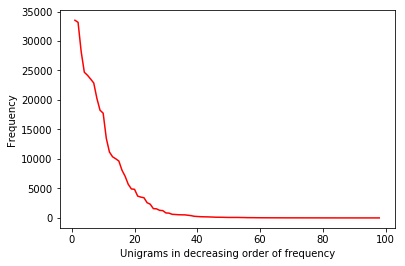

In [0]:
# Get all inputs
inputs = [line.rstrip('\n').lower().split('\t')[1] for line in open(folder + training_set_file_name, 'r', encoding='iso-8859-1')]
# using dict.get() to get count  
# of each element in string  
unigram_counts = {} 
UNIGRAM_THRESHOLD = 45
for input in inputs:
    for ch in input: 
        unigram_counts[ch] = unigram_counts.get(ch, 0) + 1
counts = sorted(unigram_counts.values(), reverse = True)
filtered_unigrams = {k: v for k, v in unigram_counts.items() if v > UNIGRAM_THRESHOLD}
print(counts)
print(filtered_unigrams)
print(len(filtered_unigrams))
print(len(counts))
print(counts[55])

# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('Unigrams in decreasing order of frequency')
plt.ylabel('Frequency')
plt.show();

[6395, 5324, 5093, 4620, 4150, 4075, 4036, 3508, 3377, 3164, 3158, 3120, 3098, 2980, 2954, 2948, 2921, 2883, 2881, 2851, 2690, 2657, 2648, 2535, 2512, 2441, 2362, 2343, 2338, 2172, 2149, 2110, 2084, 2036, 2019, 1982, 1980, 1975, 1952, 1950, 1889, 1888, 1839, 1835, 1833, 1826, 1816, 1798, 1793, 1766, 1753, 1751, 1721, 1720, 1718, 1705, 1690, 1651, 1614, 1562, 1559, 1510, 1496, 1488, 1484, 1479, 1477, 1471, 1454, 1447, 1435, 1418, 1416, 1409, 1370, 1333, 1329, 1316, 1300, 1260, 1257, 1252, 1239, 1211, 1210, 1184, 1173, 1164, 1132, 1130, 1128, 1105, 1096, 1095, 1083, 1080, 1071, 1036, 1035, 1028, 1019, 1008, 1006, 974, 965, 964, 960, 954, 940, 936, 930, 924, 921, 911, 901, 858, 854, 848, 847, 845, 830, 806, 797, 792, 791, 782, 781, 780, 774, 774, 772, 770, 767, 766, 764, 743, 731, 727, 715, 714, 712, 702, 689, 671, 670, 664, 662, 657, 651, 649, 644, 643, 639, 638, 637, 631, 629, 628, 627, 625, 621, 619, 616, 607, 605, 604, 603, 603, 599, 587, 585, 583, 580, 576, 572, 567, 564, 564, 554, 5

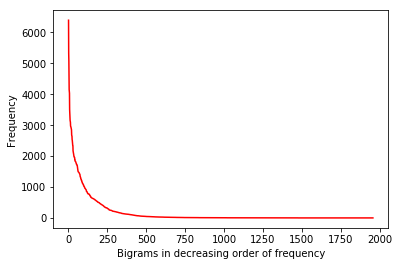

In [0]:
BIGRAM_THRESHOLD = 45
bigram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 1, 0)):
        bigram_counts[input[i: i + 2]] = bigram_counts.get(input[i: i + 2], 0) + 1

filtered_bigrams = {k: v for k, v in bigram_counts.items() if v > BIGRAM_THRESHOLD}

counts = sorted(bigram_counts.values(), reverse = True)
print(counts)
print(len(counts))
print(len(filtered_bigrams))
print(counts[512])


# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('Bigrams in decreasing order of frequency')
plt.ylabel('Frequency')
plt.show();

{'a-2': 4, '-20': 9, '200': 78, '00 ': 38, '0 g': 21, ' ge': 217, 'gel': 233, 'el ': 334, 'l c': 249, ' co': 1470, 'con': 357, 'onc': 58, 'nce': 276, 'cen': 134, 'ent': 728, 'ntr': 126, 'tra': 449, 'rat': 623, 'ate': 511, 'a-h': 7, '-hy': 16, 'hyd': 53, 'ydr': 52, 'dro': 163, 'roc': 125, 'oco': 52, 'cor': 879, 'ort': 490, 'a-m': 7, '-me': 39, 'met': 179, 'eth': 127, 'tha': 156, 'hap': 38, 'apr': 39, 'pre': 222, 'red': 216, 'a-s': 20, '-sp': 15, 'spa': 85, 'pas': 69, 'as ': 262, 's s': 172, ' s/': 6, 's/l': 3, 'a.c': 2, '.c.': 13, 'c.&': 1, '.&c': 1, 'a.p': 1, '.p.': 20, 'p.l': 3, '.l.': 4, 'a.r': 2, '.r.': 12, 'r.m': 1, '.m.': 3, 'm. ': 31, '. m': 51, ' ma': 590, 'max': 123, 'axi': 94, 'xim': 69, 'imu': 76, 'mum': 70, 'um ': 160, 'm s': 112, ' st': 528, 'str': 454, 'tre': 319, 'ren': 426, 'eng': 215, 'ngt': 237, 'gth': 148, 'th ': 427, 'h c': 125, ' ca': 599, 'cap': 378, 'apl': 122, 'ple': 203, 'let': 237, 'ets': 177, 'ts ': 184, 's 1': 143, ' 12': 142, 'a/b': 1, '/b ': 1, 'b o': 1, ' 

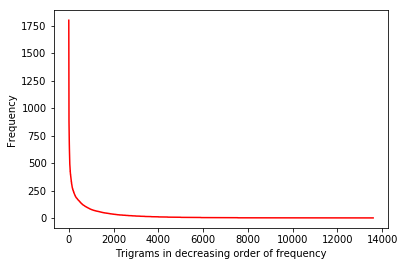

In [0]:
from collections import Counter
TRIGRAM_THRESHOLD = 45


trigram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 2, 0)):
        trigram_counts[input[i: i + 3]] = trigram_counts.get(input[i: i + 3], 0) + 1

k = Counter(trigram_counts)
highest_trigrams = k.most_common(1652)
filtered_trigrams = {k: v for k, v in trigram_counts.items() if v > TRIGRAM_THRESHOLD}
trigram_to_index = {highest_trigrams[i][0] : i for i in range(len(highest_trigrams))}
        
counts = sorted(trigram_counts.values(), reverse = True)
print(trigram_counts)
print(highest_trigrams)
print(highest_trigrams[-1])
print(filtered_trigrams)
print(len(filtered_trigrams))
print(trigram_to_index)
print(counts[2500])


# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('Trigrams in decreasing order of frequency')
plt.ylabel('Frequency')
plt.show();

[('the ', 1297), (' inc', 1225), ('tion', 912), ('inc.', 886), ('atio', 704), ('corp', 627), (' cor', 618), (' the', 614), (' of ', 575), ('ing ', 490), ('orat', 475), ('rati', 466), ('orpo', 459), ('pora', 458), ('rpor', 458), ('s in', 391), ('and ', 311), (', in', 301), (' cap', 298), ('ine ', 288), (' for', 281), (' and', 261), (' de ', 242), ('illi', 227), ('john', 220), (' tru', 219), (' fun', 208), (' str', 206), ('fund', 204), ('ion ', 195), ('ies ', 194), ('ment', 192), ('trus', 191), ('rust', 190), ('ight', 189), ('ster', 187), (' com', 186), ('stre', 183), ('ent ', 183), ('s co', 181), ('amer', 177), ('land', 177), ('es i', 177), ('char', 174), ('ter ', 173), (' in ', 173), ('nter', 173), ('e co', 170), ('ohn ', 169), ('eric', 168), ('e in', 163), ('bert', 162), ('meri', 162), ('ion.', 162), ('tren', 161), ('les ', 160), ('will', 160), ('ther', 159), ('der ', 158), ('muni', 157), ('ome ', 157), ('come', 156), ('inco', 155), (' gro', 155), (' wit', 154), ('l co', 153), ('n co'

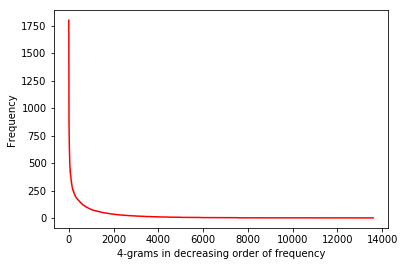

In [0]:

# Get all inputs
inputs = [line.rstrip('\n').lower().split('\t')[1] for line in open(folder + training_set_file_name, 'r', encoding='iso-8859-1')]

four_gram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 3, 0)):
        four_gram_counts[input[i: i + 4]] = four_gram_counts.get(input[i: i + 4], 0) + 1

k = Counter(four_gram_counts)
highest_trigrams = k.most_common(847)

print(highest_trigrams)
print(highest_trigrams[-1])




# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('4-grams in decreasing order of frequency')

plt.ylabel('Frequency')
plt.show();

{'a-200': 1, '-200 ': 2, '200 g': 1, '00 ge': 2, '0 gel': 15, ' gel ': 5, 'gel c': 1, 'el co': 18, 'l con': 13, ' conc': 28, 'conce': 32, 'oncen': 13, 'ncent': 20, 'centr': 31, 'entra': 32, 'ntrat': 13, 'trate': 41, 'a-hyd': 2, '-hydr': 14, 'hydro': 36, 'ydroc': 14, 'droco': 11, 'rocor': 9, 'ocort': 21, 'a-met': 1, '-meth': 3, 'metha': 10, 'ethap': 1, 'thapr': 1, 'hapre': 1, 'apred': 4, 'a-spa': 1, '-spas': 1, 'spas ': 1, 'pas s': 1, 'as s/': 1, 's s/l': 1, 'a.c.&': 1, '.c.&c': 1, 'a.p.l': 1, '.p.l.': 1, 'a.r.m': 1, '.r.m.': 1, 'r.m. ': 1, '.m. m': 1, 'm. ma': 1, '. max': 1, ' maxi': 55, 'maxim': 66, 'aximu': 63, 'ximum': 62, 'imum ': 62, 'mum s': 58, 'um st': 60, 'm str': 59, ' stre': 158, 'stren': 147, 'treng': 147, 'rengt': 147, 'ength': 148, 'ngth ': 113, 'gth c': 35, 'th ca': 33, 'h cap': 25, ' capl': 98, 'caple': 99, 'aplet': 101, 'plets': 102, 'lets ': 48, 'ets 1': 39, 'ts 12': 9, 'a/b o': 1, '/b ot': 1, 'b oti': 1, ' otic': 9, 'a/t/s': 1, 'abbok': 1, 'bboki': 1, 'bokin': 1, 'ok

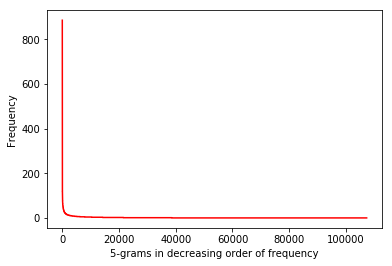

In [0]:
# Get all inputs
inputs = [line.rstrip('\n').lower().split('\t')[1] for line in open(folder + training_set_file_name, 'r', encoding='iso-8859-1')]

four_gram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 4, 0)):
        four_gram_counts[input[i: i + 5]] = four_gram_counts.get(input[i: i + 5], 0) + 1

k = Counter(four_gram_counts)
highest_trigrams = k.most_common(337)
        
counts = sorted(four_gram_counts.values(), reverse = True)
print(four_gram_counts)
print(len(counts))
print(highest_trigrams)
print(highest_trigrams[-1])
print(counts[55])


# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('5-grams in decreasing order of frequency')

plt.ylabel('Frequency')
plt.show();

{'a-200 ': 2, '-200 g': 1, '200 ge': 1, '00 gel': 2, '0 gel ': 1, ' gel c': 1, 'gel co': 1, 'el con': 2, 'l conc': 7, ' conce': 31, 'concen': 18, 'oncent': 18, 'ncentr': 18, 'centra': 29, 'entrat': 17, 'ntrate': 17, 'a-hydr': 2, '-hydro': 13, 'hydroc': 17, 'ydroco': 14, 'drocor': 11, 'rocort': 11, 'a-meth': 1, '-metha': 2, 'methap': 1, 'ethapr': 1, 'thapre': 1, 'hapred': 1, 'a-spas': 1, '-spas ': 1, 'spas s': 1, 'pas s/': 1, 'as s/l': 1, 'a.c.&c': 1, 'a.p.l.': 1, 'a.r.m.': 1, '.r.m. ': 1, 'r.m. m': 1, '.m. ma': 1, 'm. max': 1, '. maxi': 1, ' maxim': 72, 'maximu': 82, 'aximum': 81, 'ximum ': 81, 'imum s': 76, 'mum st': 76, 'um str': 76, 'm stre': 76, ' stren': 188, 'streng': 193, 'trengt': 193, 'rength': 193, 'ength ': 145, 'ngth c': 45, 'gth ca': 30, 'th cap': 30, 'h capl': 31, ' caple': 128, 'caplet': 128, 'aplets': 131, 'plets ': 59, 'lets 1': 48, 'ets 12': 13, 'a/b ot': 1, '/b oti': 1, 'b otic': 1, 'abboki': 2, 'bbokin': 2, 'bokina': 2, 'okinas': 3, 'kinase': 3, 'inase ': 2, 'nase o

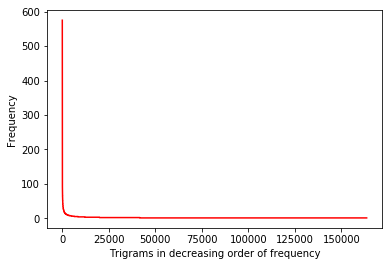

In [0]:
from collections import Counter
TRIGRAM_THRESHOLD = 50


trigram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 5, 0)):
        trigram_counts[input[i: i + 6]] = trigram_counts.get(input[i: i + 6], 0) + 1

k = Counter(trigram_counts)
highest_trigrams = k.most_common(100)
filtered_trigrams = {k: v for k, v in trigram_counts.items() if v > TRIGRAM_THRESHOLD}
trigram_to_index = {highest_trigrams[i][0] : i for i in range(len(highest_trigrams))}
        
counts = sorted(trigram_counts.values(), reverse = True)
print(trigram_counts)
print(highest_trigrams)
print(len(filtered_trigrams))
print(trigram_to_index)
print(counts[250])


# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('Trigrams in decreasing order of frequency')
plt.ylabel('Frequency')
plt.show();

{'a-200 g': 1, '-200 ge': 1, '200 gel': 1, '00 gel ': 1, '0 gel c': 1, ' gel co': 1, 'gel con': 1, 'el conc': 2, 'l conce': 6, ' concen': 12, 'concent': 13, 'oncentr': 13, 'ncentra': 13, 'centrat': 13, 'entrate': 13, 'a-hydro': 2, '-hydroc': 5, 'hydroco': 11, 'ydrocor': 9, 'drocort': 9, 'a-metha': 1, '-methap': 1, 'methapr': 1, 'ethapre': 1, 'thapred': 1, 'a-spas ': 1, '-spas s': 1, 'spas s/': 1, 'pas s/l': 1, 'a.r.m. ': 1, '.r.m. m': 1, 'r.m. ma': 1, '.m. max': 1, 'm. maxi': 1, '. maxim': 1, ' maximu': 55, 'maximum': 62, 'aximum ': 62, 'ximum s': 58, 'imum st': 58, 'mum str': 58, 'um stre': 58, 'm stren': 58, ' streng': 142, 'strengt': 147, 'trength': 147, 'rength ': 113, 'ength c': 35, 'ngth ca': 22, 'gth cap': 22, 'th capl': 22, 'h caple': 23, ' caplet': 98, 'caplets': 98, 'aplets ': 47, 'plets 1': 38, 'lets 12': 9, 'a/b oti': 1, '/b otic': 1, 'abbokin': 1, 'bbokina': 1, 'bokinas': 1, 'okinase': 2, 'kinase ': 2, 'inase o': 1, 'nase op': 1, 'ase ope': 1, 'se open': 1, 'e open-': 1, '

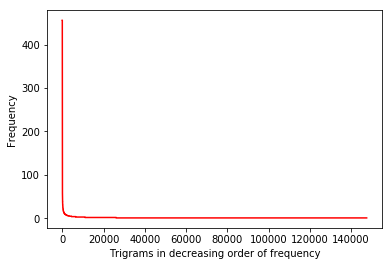

In [0]:
from collections import Counter
TRIGRAM_THRESHOLD = 50


trigram_counts = {}
for input in inputs:
    # Get all n-grams
    for i in range(max(len(input) - 6, 0)):
        trigram_counts[input[i: i + 7]] = trigram_counts.get(input[i: i + 7], 0) + 1

k = Counter(trigram_counts)
highest_trigrams = k.most_common(200)
filtered_trigrams = {k: v for k, v in trigram_counts.items() if v > TRIGRAM_THRESHOLD}
trigram_to_index = {highest_trigrams[i][0] : i for i in range(len(highest_trigrams))}
        
counts = sorted(trigram_counts.values(), reverse = True)
print(trigram_counts)
print(highest_trigrams)
print(len(filtered_trigrams))
print(trigram_to_index)
print(counts[150])


# Create count of the number of epochs
epoch_count = range(1, len(counts) + 1)
# Visualize loss history
plt.plot(epoch_count, counts, 'r-')
plt.xlabel('Trigrams in decreasing order of frequency')
plt.ylabel('Frequency')
plt.show();